In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

import matplotlib.patches as patches

In [2]:
H = 40
W = 40
h = H-1
w = W-1

n_min = 2
n_max = 5

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.26793101 0.83333333 0.15666667 0.15666667]
 [0.22997769 0.5        0.31467759 0.31467759]
 [0.63902533 0.16666667 0.25964411 0.25964411]]
[2. 2. 2.]


In [3]:
anchor_boxes = np.array([
    [0.3,0.3],
    [0.2,0.2],
    [0.1,0.1],
    [0.05,0.05],
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = j/(W-1)
        anchors[i,j,:,1] = i/(H-1)
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

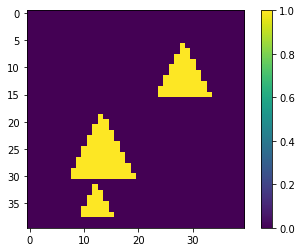

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
Ntrain     = 10000
lr         = 0.0001
print_step = 1000

In [6]:
x_tf       = tf.placeholder(shape=[1,H,W,1], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=1, output_size=64)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=64, 
                   window_size=10, hidden_size=256)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.reduce_sum(y_weights_tf*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label_tf, 
                                         logits=list_obj_logits))

loss_box   = 10*tf.reduce_sum(y_weights_tf*y_label_tf*(tf.reduce_sum(tf.square(list_box - y_box_tf), axis=1)))

lab_sum = tf.reduce_sum(y_label_tf)

loss = loss_class+loss_box

print(loss_class, loss_box, loss)

W0813 13:23:46.616261 140713121179392 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0813 13:23:46.618005 140713121179392 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/rcnn/net.py:13: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0813 13:23:46.618655 140713121179392 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0813 13:23:46.683941 140713121179392 deprecation.py:323] From /home/marsdenlab/anaconda3/lib/python3.6/site-packages/tens

Tensor("Sum:0", shape=(), dtype=float32) Tensor("mul_3:0", shape=(), dtype=float32) Tensor("add:0", shape=(), dtype=float32)


In [7]:
opt = tf.train.AdamOptimizer(lr)
train_op = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_box, gt_label = shapes.shapes_to_gt(shap)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
    
    if i%print_step == 0:
        l,lc,lb,ls = sess.run([loss, loss_class, loss_box, lab_sum], {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
        
        print("iteration {}: loss={:.3f} loss_class={:.3f} loss_box={:.5f}, lab_sum={:.3f}".format(i,l, lc, lb, ls))

iteration 0: loss=4330.824 loss_class=4321.000 loss_box=9.82446, lab_sum=12.000
iteration 1000: loss=29.596 loss_class=26.889 loss_box=2.70606, lab_sum=15.000
iteration 2000: loss=7.115 loss_class=3.926 loss_box=3.18881, lab_sum=12.000
iteration 3000: loss=4.697 loss_class=2.726 loss_box=1.97034, lab_sum=25.000
iteration 4000: loss=3.248 loss_class=1.577 loss_box=1.67066, lab_sum=18.000
iteration 5000: loss=0.775 loss_class=0.233 loss_box=0.54230, lab_sum=12.000
iteration 6000: loss=1.125 loss_class=0.145 loss_box=0.98014, lab_sum=16.000
iteration 7000: loss=8.165 loss_class=4.925 loss_box=3.24046, lab_sum=17.000
iteration 8000: loss=7.940 loss_class=1.662 loss_box=6.27844, lab_sum=22.000
iteration 9000: loss=9.584 loss_class=9.021 loss_box=0.56367, lab_sum=17.000


In [10]:
x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)

gt_t, gt_matched, gt_labels, gt_weights =\
box.create_box_gt(anchors_1d, gt_box)

x = x.reshape((1,H,W,1))

out_box, l_box, out_obj = sess.run([rpn_box, list_box, rpn_obj], {x_tf:x})

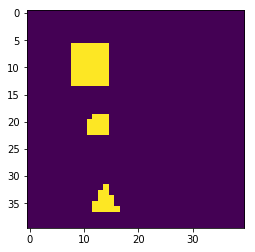

0


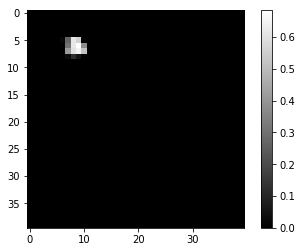

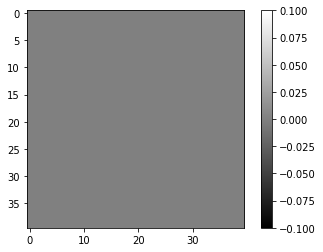

1


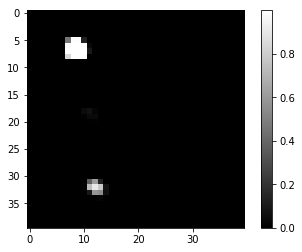

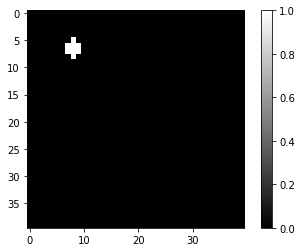

2


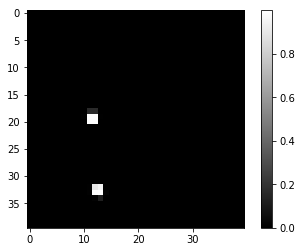

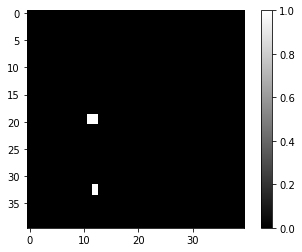

3


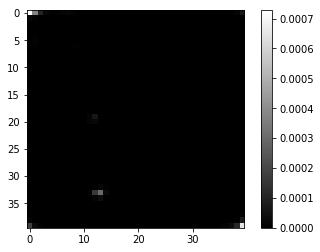

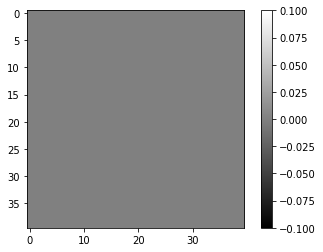

weights
0


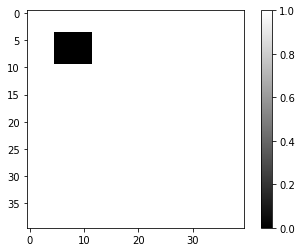

1


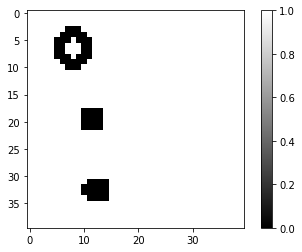

2


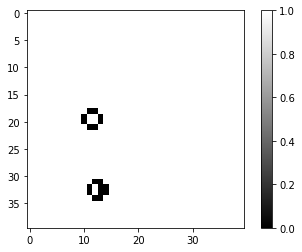

3


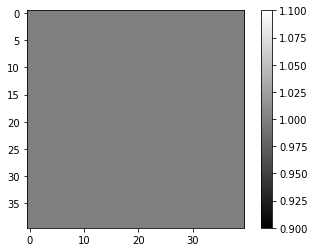

In [11]:
lab = gt_labels.reshape((H,W,K))
weights = gt_weights.reshape((H,W,K))

plt.figure()
plt.imshow(x[0,:,:,0])
plt.show()

for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(out_obj[0,:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(lab[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
print("weights")
for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(weights[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()

In [12]:
predicted_boxes, predicted_obj = sess.run([list_box, list_obj],{x_tf:x})

In [13]:
anch_p = anchors.reshape((-1,4))[predicted_obj>0.99]
print(anch_p)

[[0.20512821 0.15384615 0.2        0.2       ]
 [0.23076923 0.15384615 0.2        0.2       ]
 [0.25641026 0.15384615 0.2        0.2       ]
 [0.20512821 0.17948718 0.2        0.2       ]
 [0.23076923 0.17948718 0.2        0.2       ]
 [0.25641026 0.17948718 0.2        0.2       ]
 [0.20512821 0.20512821 0.2        0.2       ]
 [0.23076923 0.20512821 0.2        0.2       ]
 [0.28205128 0.48717949 0.1        0.1       ]
 [0.30769231 0.48717949 0.1        0.1       ]
 [0.28205128 0.51282051 0.1        0.1       ]
 [0.30769231 0.51282051 0.1        0.1       ]
 [0.30769231 0.84615385 0.1        0.1       ]
 [0.33333333 0.84615385 0.1        0.1       ]]


In [14]:
bp = predicted_boxes[predicted_obj>0.99]
print(bp)

[[ 0.02596497  0.05782681 -0.03624071  0.07533004]
 [-0.09437054  0.05524185 -0.03078667  0.07331864]
 [-0.19284506  0.05729319 -0.01673192  0.07062291]
 [ 0.02671846 -0.06588132 -0.03946112  0.07217167]
 [-0.0981888  -0.06920724 -0.02219281  0.06860425]
 [-0.19345635 -0.06967504 -0.02674736  0.05123118]
 [ 0.01207187 -0.19426939 -0.03169219  0.05777621]
 [-0.08918183 -0.18967468 -0.0268136   0.05072532]
 [ 0.05905858  0.06974055  0.15307543  0.16953304]
 [-0.08735611  0.08000697  0.14931601  0.16647404]
 [ 0.06635688 -0.11370578  0.16106239  0.18039037]
 [-0.06914469 -0.11670826  0.1568983   0.19467811]
 [ 0.04618843 -0.13035181  0.2178738   0.2554819 ]
 [-0.09004178 -0.10538092  0.22414479  0.26218665]]


In [15]:
gt_p = gt_t[predicted_obj>0.99]
print(gt_p)

[[ 0.01768966  0.06410256 -0.12511751  0.03800001]
 [-0.11051547  0.06410256 -0.12511751  0.03800001]
 [-0.2387206   0.06410256 -0.12511751  0.03800001]
 [ 0.01768966 -0.06410256 -0.12511751  0.03800001]
 [-0.11051547 -0.06410256 -0.12511751  0.03800001]
 [-0.2387206  -0.06410256 -0.12511751  0.03800001]
 [ 0.01768966 -0.19230769 -0.12511751  0.03800001]
 [-0.11051547 -0.19230769 -0.12511751  0.03800001]
 [ 0.14305684  0.12820513  0.11981304  0.11981304]
 [-0.11335341  0.12820513  0.11981304  0.11981304]
 [ 0.14305684 -0.12820513  0.11981304  0.11981304]
 [-0.11335341 -0.12820513  0.11981304  0.11981304]
 [ 0.09855406 -0.12820513  0.24834546  0.24834546]
 [-0.15785619 -0.12820513  0.24834546  0.24834546]]


In [16]:
bp_n = box.inv_bbox_transform(anch_p, bp)
gt_n = box.inv_bbox_transform(anch_p, gt_p)
print(bp_n*H)
print(gt_n*H)
print(gt_box*H)

[[ 8.41284795  6.61646063  7.7152648   8.62591934]
 [ 8.47580488  6.59578092  7.75745916  8.60858727]
 [ 8.71364977  6.61219169  7.86725807  8.58541203]
 [ 8.41887589  6.65243662  7.69045877  8.59871864]
 [ 8.44525887  6.62582929  7.8244133   8.56809807]
 [ 8.70875944  6.62208689  7.78885746  8.42052937]
 [ 8.3017032   6.65097309  7.75043774  8.4758234 ]
 [ 8.51731457  6.6877308   7.78834152  8.41627121]
 [11.5182856  19.76614168  4.66165161  4.73900604]
 [11.95826786 19.80720738  4.64415932  4.72453165]
 [11.54747878 20.05799741  4.69903326  4.79073906]
 [12.03111355 20.04598749  4.67950678  4.85967922]
 [12.49244601 33.3247466   4.97372055  5.16433477]
 [12.97316622 33.42463019  5.0050087   5.19907665]]
[[ 8.34664545  6.66666667  7.05914568  8.30984991]
 [ 8.34664545  6.66666667  7.05914568  8.30984991]
 [ 8.34664545  6.66666667  7.05914568  8.30984991]
 [ 8.34664545  6.66666667  7.05914568  8.30984991]
 [ 8.34664545  6.66666667  7.05914568  8.30984991]
 [ 8.34664545  6.66666667  7.0

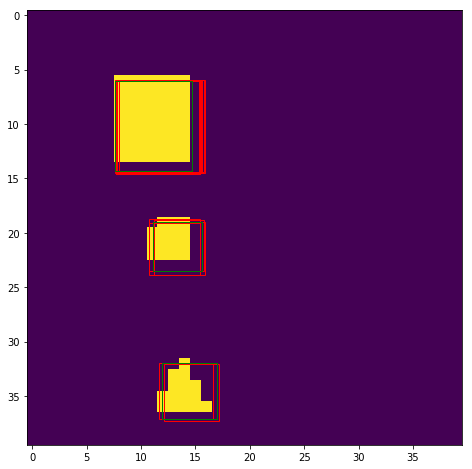

In [19]:
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(8,8))

# Display the image
ax.imshow(x[0,:,:,0])

# Create a Rectangle patch
for b in bp_n:
    rect = patches.Rectangle((b[0]*w-0.5,b[1]*h-0.5),b[2]*H,b[3]*H,linewidth=1,
                             edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Create a Rectangle patch
for b in gt_box:
    rect = patches.Rectangle((b[0]*w-0.5,b[1]*h-0.5),b[2]*H,b[3]*H,linewidth=1,
                             edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()